In [1]:
import sys
sys.path.append('../../../')
import cxsystem2.neurodynlib as nd
from brian2.units import *
import brian2 as b2
import matplotlib.pyplot as plt
from brian2tools import brian_plot

#b2.codegen.target = 'numpy'

## Synaptic currents

Synaptic receptors can be added to the model equations easily. For background reading on synapses, see [Section 3.1](https://neuronaldynamics.epfl.ch/online/Ch3.S1.html) in the Neuronal Dynamics book.

Let's first load the parameters for a regular spiking AdEx neuron.

In [2]:
naud2008_json = 'naud2008_table1.json'
x = nd.AdexNeuron()
x.list_neurons_in_json(naud2008_json)

['cNA',
 'cAD',
 'RS',
 'Fig_4a',
 'Fig_4b',
 'Fig_4c',
 'Fig_4d',
 'Fig_4e',
 'Fig_4f',
 'Fig_4g',
 'Figs_4h']

Let's load the parameters and stimulate to make sure it's the model we want to use

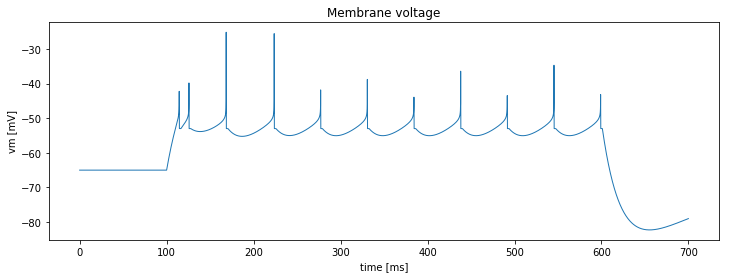

In [3]:
x.read_json(naud2008_json, 'RS')
input = nd.input_factory.get_step_current(t_start=100, t_end=600, unit_time=ms, amplitude=150*pA)
statemon, spikemon = x.simulate_neuron(I_stim=input, simulation_time=700*ms)
x.plot_vm(statemon)

Now, let's check the equations first without any synaptic conductances

In [4]:
x.get_neuron_equations()

dvm/dt = (DeltaT*gL*exp((-VT + vm)/DeltaT) + gL*(EL - vm) - w)/C : volt (unless refractory)
dw/dt = (a*(-EL + vm) - w)/tau_w : amp


Then, let's add "simple excitatory" conductance characterized by single-exponential decay and check the equations again:

In [5]:
x.set_excitatory_receptors('SIMPLE_E')
x.set_neuron_parameters(Ee=0*mV, tau_e=3.0*ms)
x.get_neuron_equations()

dvm/dt = (DeltaT*gL*exp((-VT + vm)/DeltaT) + gL*(EL - vm) + ge*(Ee - vm) - w)/C : volt (unless refractory)
dw/dt = (a*(-EL + vm) - w)/tau_w : amp
dge/dt = -ge/tau_e : siemens


Then we'll create a Brian2 NeuronGroup with the same properties as our model neuron:

In [6]:
neuron = b2.NeuronGroup(1, model=x.get_neuron_equations(),
                            namespace=x.get_neuron_parameters(),
                            reset=x.get_reset_statements(),
                            threshold=x.get_threshold_condition(), 
                            refractory=x.get_refractory_period())

neuron.set_states(x.get_initial_values())

Let's then add some Poisson-distributed synaptic input and set-up the simulation

In [7]:
synaptic_input = b2.PoissonInput(neuron, 'ge', 100, 10*Hz, weight=1.5*nS)
neuron_vm = b2.StateMonitor(neuron, ['vm'], record=True)
net = b2.Network(neuron, synaptic_input, neuron_vm)

Finally, we can run the simulation

In [8]:
net.run(1000*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


After simulation, we can plot the membrane voltage

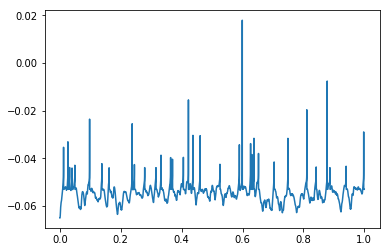

In [9]:
plt.plot(neuron_vm.t, neuron_vm.vm[0])